# Electric Network Reconstruction System ENRS
## TFM 2025  
### Autor : Andres Felipe Vargas Nuñez 
![](../Static_files/logo_ucm_ntic.png )

##### Este archivo Transforma y unifica data reportada por los nodos y carga perteneciente a una red eléctrica de tipo radial.

In [1]:
import os 
import uuid
import joblib
import random

from datetime import datetime

import numpy as np
import pandas as pd
import pandapower as pp
import matplotlib.pyplot as mplt
import pandapower.networks as nw
import plotly.graph_objects as go

import pandapower.plotting as plt
import pandapower.timeseries as ts
from pandapower.control import ConstControl

from pandapower.timeseries.data_sources.frame_data import DFData


#### Métodos comunes de operación y manejo de datos.

In [2]:
def create_custom_network(num_buses, num_loads, connection_type="tree"):
    # Crear una red vacía
    net = pp.create_empty_network()
    buses = [pp.create_bus(net, vn_kv=110, name=f"Bus {i+1}") for i in range(num_buses)]

    # loads = [
    #     pp.create_load(net, bus=buses[random.randint(0, num_buses - 1)], 
    #                    p_mw=random.uniform(1.0, 5.0), 
    #                    q_mvar=random.uniform(0.5, 2.5), 
    #                    name=f"Load {i+1}") 
    #     for i in range(num_loads)
    # ]
    std_types = pp.available_std_types(net, element='line')
    if connection_type == "tree":
        for i in range(1, num_buses):
            parent_bus = random.choice(buses[:i])
            configuracion_aleatoria = random.choice(list(std_types.index))
            pp.create_line(net,name=f"line {i+1}" ,from_bus=parent_bus, to_bus=buses[i], length_km=(random.uniform(0.2, 10.0)), std_type=configuracion_aleatoria)
                
    elif connection_type == "mesh":
        for i in range(1, num_buses):
            for j in range(i):
                if random.random() < 0.5:  
                    configuracion_aleatoria = random.choice(list(std_types.index))
                    pp.create_line(net, from_bus=buses[i], to_bus=buses[j], length_km=(random.uniform(0.2, 10.0)), std_type=configuracion_aleatoria)
                    
    elif connection_type == "ring":
        for i in range(num_buses):
            configuracion_aleatoria = random.choice(list(std_types.index))
            pp.create_line(net, from_bus=buses[i], to_bus=buses[(i+1) % num_buses], length_km=(random.uniform(0.2, 10.0)), std_type=configuracion_aleatoria)

            if random.random() < 0.3:  
                distant_bus = random.choice(buses)
                if distant_bus != buses[i] and distant_bus != buses[(i+1) % num_buses]:
                    pp.create_line(net, from_bus=buses[i], to_bus=distant_bus, length_km=(random.uniform(0.2, 10.0)), std_type=configuracion_aleatoria)

    else:
        raise ValueError("Tipo de conexión no válido. Usa 'tree' o 'ring'.")


    nodos_finales = [bus for bus in buses if len(net.line[(net.line.from_bus == bus) | (net.line.to_bus == bus)]) == 1]
    print(nodos_finales)
    num_loads = len(nodos_finales)  # Puedes ajustar esto según tus necesidades
    loads = [
        pp.create_load(net, bus=bus,
                    p_mw=random.uniform(1.0, 5.0), 
                    q_mvar=random.uniform(0.5, 2.5), 
                    name=f"Load {i+1}") 
        for i, bus in enumerate(nodos_finales)
    ]

    slack_bus = 0
    pp.create_gen(net, bus=slack_bus, p_mw=random.uniform(5.0, 10.0), vm_pu=1.02, slack=True, name="Slack Gen")
    pp.create_ext_grid(net, bus=slack_bus, vm_pu=1.02)

    return net

def create_network(net_type=0):
    if net_type == 0:
        net =nw.simple_four_bus_system()
    elif net_type == 1:   
        net =nw.case24_ieee_rts()
    elif net_type == 2:
        net = nw.case30()
    else:
        net = nw.case14()
    return net

def calculate_resistance(distance_km):
    resistivity = 0.017 
    area = 1.0  
    resistance = (resistivity / area) * distance_km
    return resistance

def configure_output_writer(net, output_path):
    return ts.OutputWriter(net, output_path=output_path, output_file_type=".xlsx")

def create_profile_data(time_steps, net):
    profile_data = np.random.rand(time_steps, len(net.load))
    return ts.DFData(pd.DataFrame(profile_data))

def configure_constant_load_control(net, ds):
    return ConstControl(net, element='load', element_index=net.load.index, variable='scaling', data_source=ds, profile_name=net.load.index)

def log_variables(ow):
    ow.log_variable('res_bus', 'vm_pu')
    ow.log_variable('res_line', 'loading_percent')
    ow.log_variable('res_gen', 'p_mw')
    ow.log_variable('res_load', 'p_mw')
    ow.log_variable('res_load', 'q_mvar')

def run_simulation(net, time_steps) -> bool:
    try:
        ts.run_timeseries(net, time_steps)
        return True
    except Exception as e:
        print(f"Error durante la ejecución de series temporales: {e}")
        return False

def load_results(output_path):
    rename_columns ={"Unnamed: 0":"time_step"}
    lines_config = pd.read_csv(f'{output_path}/line_configuration.csv', header=0)
    loads_config = pd.read_csv(f'{output_path}/loads_configuration.csv', header=0)


    res_bus = pd.read_excel(f'{output_path}/res_bus/vm_pu.xlsx', header=[0])
    res_p_bus = pd.read_excel(f'{output_path}/res_bus/p_mw.xlsx', header=[0])
    res_q_bus = pd.read_excel(f'{output_path}/res_bus/q_mvar.xlsx', header=[0])
    va_degree_bus = pd.read_excel(f'{output_path}/res_bus/va_degree.xlsx', header=[0])
    res_bus = res_bus.rename(columns=rename_columns).set_index('time_step')
    res_p_bus = res_p_bus.rename(columns=rename_columns).set_index('time_step')
    res_q_bus = res_q_bus.rename(columns=rename_columns).set_index('time_step')
    va_degree_bus = va_degree_bus.rename(columns=rename_columns).set_index('time_step')

    res_bus.columns = [f" vm_pu_{col}"  for col in res_bus.columns]
    res_p_bus.columns = [f" res_p_{col}"  for col in res_p_bus.columns]
    res_q_bus.columns = [f" res_q_{col}"  for col in res_q_bus.columns]
    va_degree_bus.columns = [f" va_degree_{col}"  for col in va_degree_bus.columns]

    res_bus = res_bus.join(res_p_bus)
    res_bus = res_bus.join(res_q_bus)
    res_bus = res_bus.join(va_degree_bus)

    return (res_bus,
    lines_config,
    loads_config )

def format_load_data(res_load, load_bus_ids, value_name):
    res_load.columns = ['time_step'] + [f'{bus}' for bus in load_bus_ids]
    res_load = res_load[~res_load['time_step'].isna()]
    res_load = res_load.reset_index().melt(id_vars=['index'], var_name='node_id', value_name=value_name)
    res_load = res_load.query("node_id != 'time_step'")
    return res_load

def format_bus_data(res_bus, max_range,value_name='vm_pu'):
    res_bus.columns = ['time_step', 'line_id'] + [f'{bus}' for bus in range(1, max_range)]
    res_bus = res_bus[~res_bus['time_step'].isna()]
    res_bus = res_bus.reset_index().melt(id_vars=['index'], var_name='node_id', value_name= value_name)
    res_bus = res_bus.query("node_id != 'time_step' & node_id != 'line_id'")
    return res_bus

def merge_data(res_bus, res_load_p_mw, res_load_q_mvar,bus_load_p,bus_load_q):
    res_load_p_mw.set_index(['index', 'node_id'], inplace=True)
    res_bus.set_index(['index', 'node_id'], inplace=True)
    res_load_q_mvar.set_index(['index', 'node_id'], inplace=True)
    df_combined = res_bus.join(res_load_p_mw, on=['index', 'node_id'] ,lsuffix='__bus', rsuffix='_loadp') 
    df_combined = df_combined.join(res_load_q_mvar, on=['index', 'node_id'], how="left",rsuffix='_loadq')
    df_combined = res_bus.join(bus_load_p, on=['index', 'node_id'] ,lsuffix='__bus', rsuffix='_loadp') 
    df_combined = df_combined.join(bus_load_q, on=['index', 'node_id'], how="left",rsuffix='_loadq')

    return df_combined

def create_incidence_matrix(net):
    incidence_matrix = pp.topology.create_nxgraph(net)
    return pd.DataFrame(nw.to_pandas_adjacency(incidence_matrix, nodelist=net.bus.index, weight='weight'))

def create_line_data(net):
    line_data = []
    for line in net.line.index:
        from_bus = net.line.from_bus.at[line]
        to_bus = net.line.to_bus.at[line]
        length_km = net.line.length_km.at[line]
        r_ohm_per_km = net.line.r_ohm_per_km.at[line]
        line_data.append({'line_id': line, 'from_bus': from_bus, 'to_bus': to_bus, 'length_km': length_km, 'r_ohm_per_km': r_ohm_per_km})
    return pd.DataFrame(line_data)

def print_inciden_matrix(df):
    df = df.applymap(lambda x: 0 if x == '0' or x == 0 else 1)

def incidence_matrix(line_df):
    from_buses = line_df['from_bus']
    to_buses = line_df['to_bus']
    length_kms = line_df['length_km']
    r_ohm_per_kms = line_df['r_ohm_per_km']
    num_buses = max(from_buses.max(), to_buses.max()) + 1
    num_lines = len(line_df)
    incidence_matrix = np.zeros((num_lines, num_buses), dtype=tuple)
    # (length_km,r_ohm_per_km
    for i, (from_bus, to_bus,length_km,r_ohm_per_km) in enumerate(zip(from_buses, to_buses,length_kms,r_ohm_per_kms)):
        incidence_matrix[i,to_bus] = 3
        incidence_matrix[i,from_bus] = 5

    df = pd.DataFrame(incidence_matrix, columns=[i for i in range(num_buses)], index=[j for j in range(num_lines)])

    return df

def plot_simple_df_net(df, is_print_lines=False):
    df = df.transpose()
    net = pp.create_empty_network()
    buses = [pp.create_bus(net, vn_kv=110, name=f"Bus {bus}") for bus in range(len(df.index))]
    number_line = 0

    for col in df.columns:
        from_bus = None
        to_bus = None
        for i, value in df[col].items():
                if value == 5 and from_bus is None:
                        from_bus = int(i)
                if value == 3 and to_bus is None:
                        to_bus = int(i)
        
        if  (not from_bus is None and 
        not to_bus is None ): 
                length_km = 10
                pp.create_line(net, name=f"number_line{number_line}", from_bus=from_bus, to_bus=to_bus, length_km=length_km, std_type="NAYY 4x50 SE")
                number_line += 1

    slack_bus = 0 
    pp.create_gen(net, bus=slack_bus, p_mw=random.uniform(5.0, 10.0), vm_pu=1.02, slack=True, name="Slack Gen")
    other_gen_buses = random.sample([b for b in buses if b != slack_bus], k=max(1,  len(df.index) // 4))
    for bus in other_gen_buses:
        pp.create_gen(net, bus=bus, p_mw=random.uniform(3.0, 6.0), vm_pu=1.02, name=f"Gen {bus}")

    pp.create_ext_grid(net, bus=slack_bus, vm_pu=1.02)
    fig = plt.simple_plot(net)
    if is_print_lines:
        print(net.line)

def comparar_matrices(matrix1, matrix2):
    matrix1 = np.array(matrix1)
    matrix2 = np.array(matrix2)
    
    df_resta = np.abs(matrix1 - matrix2)
    # Sumar todos los valores absolutos
    suma_total = np.sum(df_resta)
    return suma_total

def ajustar_celdas(df):
    df_nuevo = pd.DataFrame(0, index=df.index, columns=df.columns)
    for col in df.columns:
        top_values = df[col].nlargest(2)
        suma_top_values = top_values.sum()
        if suma_top_values> 0.4 :
            top_indices = df[col].nlargest(2).index
            df_nuevo.loc[top_indices, col] = 1

    return df_nuevo

def print_bw_matrix(df):
    mplt.matshow(df, cmap='gray')
    mplt.xticks(ticks=np.arange(df.shape[1]), labels=df.columns)
    mplt.yticks(ticks=np.arange(df.shape[0]), labels=df.index)
    mplt.colorbar()
    mplt.show()

def print_int_matrix(df,text="Generate Model Data"):
    print("*" *30 + text + "*"*30)
    print( "*"*60 + "*" *len(text) )
    print(df)

def plot_and_print_result(df,text:str="Generate Model Data" , type_output:int = 0):
    if type_output == 1 :
        print_int_matrix(df,text)
    elif type_output ==  2:
        print_bw_matrix(df)
    elif type_output ==  3:
        plot_simple_df_net(df)
    return True

#### Métodos de lectura de archivos , unificación de datos.

In [3]:
def transform_net_data_to_df(output_path):
    res_bus, lines_config, loads_config   = load_results(output_path)
    loads_number = len(loads_config)
    incidence_matrix_df = incidence_matrix(lines_config)
    nodes_numbers = incidence_matrix_df.shape[1]
    scale_loads =loads_config[["bus","scaling"]]
    all_buses = pd.DataFrame({'bus': range(26)})
    df_complete = pd.merge(all_buses, scale_loads, on='bus', how='left')
    df_complete['scaling'].fillna(0, inplace=True)
    scale_loads = df_complete.pivot(columns='bus', values='scaling')

    scale_loads.columns = [f" scale_loads_{col}"  for col in scale_loads.columns]
    diagonal_values = scale_loads.values.diagonal()

    # Crear un DataFrame con la fila condensada de los valores diagonales
    diagonal_df = pd.DataFrame([diagonal_values], columns=scale_loads.columns)
    for col in scale_loads.columns:
        res_bus[col]= diagonal_df[col].values[0]

    # print(res_bus.head(2))
    # res_bus = res_bus.join(scale_loads)
    # print(scale_loads)
    res_bus['nodes_numbers']= nodes_numbers / 25
    res_bus['loads_number']= (loads_number-1 ) / 25
    train_base_output_path = output_path.replace("net_data","train_data")


    if not os.path.exists(train_base_output_path):
        os.makedirs(train_base_output_path)

    matrix_output_path = f"{train_base_output_path}/indicen_matriz"
    if not os.path.exists(matrix_output_path):
        os.makedirs(matrix_output_path)
        incidence_matrix_df.to_csv(f"{matrix_output_path}/incidence_matrix.csv")

    scenario_output_path = f"{train_base_output_path}/load"
    if not os.path.exists(scenario_output_path):
        os.makedirs(scenario_output_path)
            
    res_bus.to_csv(f"{scenario_output_path}/load.csv",header=True)

#### Configuración ruta de archivos a procesar.



In [4]:
base_output_path = f"../Data-3"
folder_name = "Validation"

In [5]:
base_output_net_data_path=f"{base_output_path}/net_data/{folder_name}"

nets_data_files = [os.path.join(base_output_net_data_path, nombre) for nombre in os.listdir(base_output_net_data_path)]
for net_root in nets_data_files:
    transform_net_data_to_df(net_root)

C:\Users\afgvn\AppData\Local\Temp\ipykernel_25596\2120902459.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_complete['scaling'].fillna(0, inplace=True)
C:\Users\afgvn\AppData\Local\Temp\ipykernel_25596\2120902459.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For examp

#### Verificación de la transformación de la información y visualizando la red en forma de grafo.

<>:1: SyntaxWarning: invalid escape sequence '\i'
<>:1: SyntaxWarning: invalid escape sequence '\i'
C:\Users\afgvn\AppData\Local\Temp\ipykernel_25596\3959710427.py:1: SyntaxWarning: invalid escape sequence '\i'
  csv_file = f'{base_output_path}/train_data/{folder_name}/case_net_generate_n_22_scenario_1/indicen_matriz\incidence_matrix.csv'
No or insufficient geodata available --> Creating artificial coordinates. This may take some time


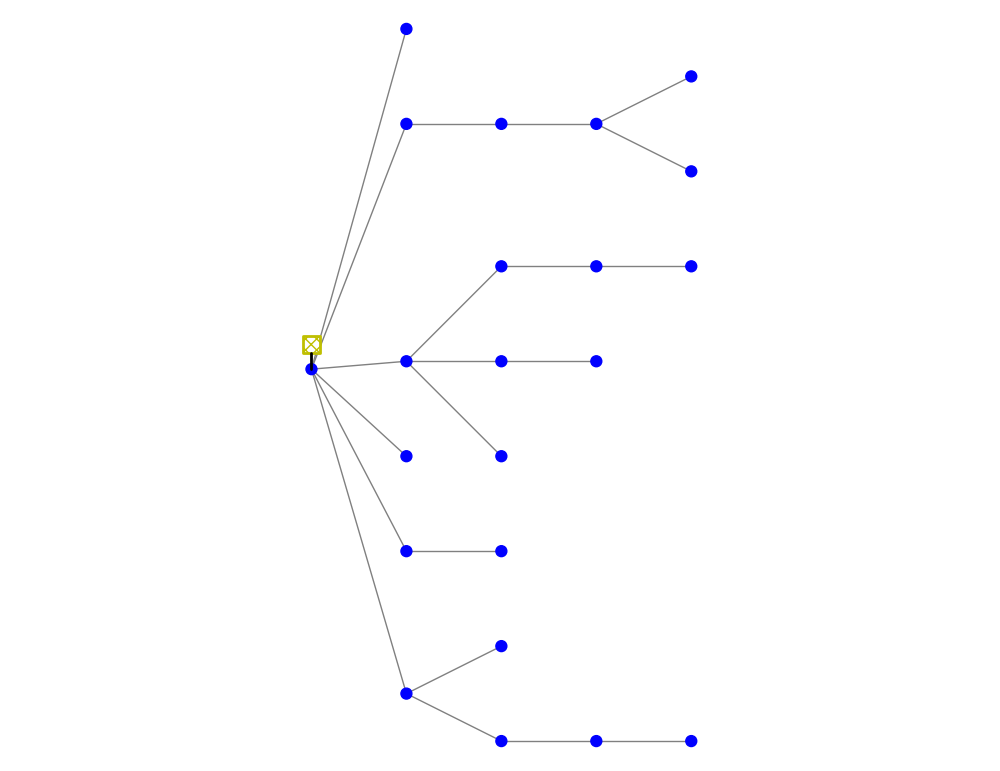

In [6]:
csv_file = f'{base_output_path}/train_data/{folder_name}/case_net_generate_n_22_scenario_1/indicen_matriz\incidence_matrix.csv'
df_test = pd.read_csv(csv_file, index_col=[0])

plot_simple_df_net(df_test)